# **1. Data Gathering**

This section gathers data for analysis, including stock information and historical prices.

In [ ]:
# Ensure all required packages are installed
try:
    import beautifulsoup4
    import yfinance
    import backtesting
except ImportError:
    !pip install beautifulsoup4 yfinance backtesting


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
from scipy.stats import pearsonr, skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from statistics import mean, stdev

# Configure visualization styles
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline


## 2. Fetch S&P 500 Stock Data

In this section, we:
- Scrape the list of S&P 500 companies from Wikipedia.
- Use the `yfinance` library to gather historical stock data.

In [ ]:
# Scrape S&P 500 stock list from Wikipedia
url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
try:
    response = requests.get(url)
    response.raise_for_status()
    soup = bs(response.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})

    # Extract ticker symbols, sectors, and sub-sectors
    tickers = []
    for row in table.findAll('tr')[1:]:
        cells = row.findAll('td')
        ticker = cells[0].text.strip()
        sector = cells[3].text.strip()
        sub_sector = cells[4].text.strip()
        tickers.append([ticker, sector, sub_sector])

    # Create a DataFrame from the scraped data
    ticker_df = pd.DataFrame(tickers, columns=['Ticker', 'Sector', 'Sub-Sector'])
    print(f"Successfully scraped {len(ticker_df)} tickers.")
except Exception as e:
    print(f"Error fetching S&P 500 data: {e}")

# Define parameters for historical data
start_date = '2018-07-01'
end_date = '2022-10-01'
output_file = f'all_stocks_{start_date}_{end_date}.csv'


## Download data from yfinance

In [ ]:
for tkr in tickers:
  single_stock_pd = yf.download(tickers=tkr[0], start=start_date, end=end_date,auto_adjust=True, progress=False)
  single_stock_pd['stock'] = tkr[0]
  single_stock_pd['sector'] = tkr[1]
  single_stock_pd['sub_sector'] = tkr[2]
  all_df = all_df.append(single_stock_pd)

all_df.to_csv(fname_string)
all_df = pd.read_csv(fname_string)

# **Part 1**

## Calculate our Feature & Target values for all stocks


In [ ]:
def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

In [ ]:
# Split the data to segments (6 months features, 3 months labelling)
FEATURES_SIZE = 180 
LABELLING_SIZE = 90

start_train_features_day = 0
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1 
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE
all_features_train_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
all_labelling_train_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]

179.0
88.0


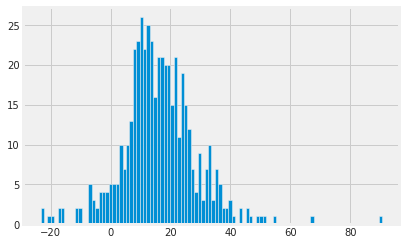

In [ ]:
# Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))
train_returns.hist(bins=100)

# Make sure that the features are 6 months
print(all_features_train_df['t0'].max() - all_features_train_df['t0'].min())
# Make sure that the labelling is 3 months
print(all_labelling_train_df['t0'].max() - all_labelling_train_df['t0'].min())

In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return
threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

In [ ]:
# Creating a monthly df for calculations
features_df = all_features_train_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)
monthly_features_df = features_df.groupby(['stock','sector','sub_sector','month_index']).apply(calculate_returns).reset_index(name = 'monthly_return')

# index return
avg_index_returns = monthly_features_df.groupby('month_index')['monthly_return'].mean().reset_index(name = 'avg_index_returns')
monthly_features_df = monthly_features_df.merge(avg_index_returns, how='inner', left_on='month_index', right_on='month_index')
monthly_features_df['stock_index_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_index_returns']

# weighted sum (our feature)
single_feature_df = pd.DataFrame(columns=['stock', 'weighted_sum'])
for stock in monthly_features_df['stock'].unique():
  sum = 0
  for i in range(6):
    monthly_return = pd.to_numeric(monthly_features_df.loc[(monthly_features_df['stock'] == stock) & (monthly_features_df['month_index'] == i)]['monthly_return'])
    index_return = pd.to_numeric(monthly_features_df.loc[(monthly_features_df['stock'] == stock) & (monthly_features_df['month_index'] == i)]['avg_index_returns'])
    if monthly_return.to_numpy().size > 0 and index_return.to_numpy().size > 0:
      sum += ((i+1)/21) * (monthly_return.iloc[0] * index_return.iloc[0])
  temp_df = pd.DataFrame([[stock, sum]], columns=['stock', 'weighted_sum'])
  single_feature_df = pd.concat([single_feature_df, temp_df], ignore_index=True)

single_feature_df = single_feature_df.sort_values(by=['stock'])
single_feature_df

,stock,weighted_sum
0,A,22.834801
1,AAL,41.867094
2,AAP,19.582895
3,AAPL,13.305834
4,ABBV,11.088798
...,...,...
486,YUM,8.827551
487,ZBH,18.491837
488,ZBRA,29.821916
489,ZION,20.850668


Our feature is a weighted sum of the 6 months return divided by the index return in order to normalize the results.
In our calculation we gave higher weight to later months because we've noticed that they have higher impact on the prediction.

In [ ]:
# Adding a binary target column for our classification 
single_feature_df.loc[single_feature_df['stock'].isin(good),'target'] = 1
single_feature_df['target'].fillna(0,inplace=True)
single_feature_df['target'].value_counts()

# Calculating the stock return in the 3 month period
stock_returns = train_returns.to_frame(name = 'stock_returns')
intersection_df = stock_returns.merge(single_feature_df, how = 'inner', on = 'stock')

intersection_df

,stock,stock_returns,weighted_sum,target
0,A,21.163682,22.834801,1.0
1,AAL,-0.758527,41.867094,0.0
2,AAP,9.319022,19.582895,0.0
3,AAPL,20.333414,13.305834,1.0
4,ABBV,-10.940567,11.088798,0.0
...,...,...,...,...
487,YUM,9.225103,8.827551,0.0
488,ZBH,24.167308,18.491837,1.0
489,ZBRA,33.399114,29.821916,1.0
490,ZION,12.829632,20.850668,0.0


## Making predictions based on our feature & regression

In [ ]:
# Classifing every stock based on the threshold (median of our feature)
feature_threshold = intersection_df['weighted_sum'].median()
intersection_df['feature_predict'] = intersection_df['weighted_sum']>feature_threshold
intersection_df['feature_predict'] = intersection_df['feature_predict'].astype(float)

intersection_df

,stock,stock_returns,weighted_sum,target,feature_predict
0,A,21.163682,22.834801,1.0,1.0
1,AAL,-0.758527,41.867094,0.0,1.0
2,AAP,9.319022,19.582895,0.0,0.0
3,AAPL,20.333414,13.305834,1.0,0.0
4,ABBV,-10.940567,11.088798,0.0,0.0
...,...,...,...,...,...
487,YUM,9.225103,8.827551,0.0,0.0
488,ZBH,24.167308,18.491837,1.0,0.0
489,ZBRA,33.399114,29.821916,1.0,1.0
490,ZION,12.829632,20.850668,0.0,1.0


In [ ]:
#Correlation
x = intersection_df['weighted_sum'] #value of the features
y = intersection_df['stock_returns'] #actual return from the test
r, p = pearsonr(x, y) #Calculate the correlation coefficient
print("Pearson correlation coefficient: ", r) 
print("p-value: ", p)

#Regression
x = np.array(intersection_df['weighted_sum']).reshape(-1, 1)
y = np.array(intersection_df['stock_returns'])
reg = LinearRegression().fit(x, y)
print("Intercept: ", reg.intercept_)
print('Coefficient :',reg.coef_)
predictedvalue = reg.predict(x)
print("Predicted value: ", predictedvalue)

Pearson correlation coefficient:  0.201787410485726
p-value:  6.453448092410905e-06
Intercept:  11.927116214549827
Coefficient : [0.22512462]
Predicted value:  [17.06779202 21.35242973 16.33570802 14.92258693 14.42347761 17.91461841
 14.62564034 15.79299784 17.11793341 16.41369866 16.50058965 15.30733942
 17.4299353  19.30537799 12.64748954 12.11019335 14.11703854 14.53233987
 19.32956449 16.17876572 14.19998134 16.92435865 17.40328471 22.24685259
 20.47751864 13.94222734 18.2533548  19.33642574 15.13479475 26.62387633
 17.99675614 15.25803846 20.00739634 12.15250073 19.7869122  18.53771413
 19.04590098 15.11652453 18.75347178 20.89385233 13.80395789 14.81490518
 16.20180774 13.81370699 12.98840688 14.59451973 14.46546477 13.07089975
 16.8623753  12.6980187  17.57676157 13.88254514 15.0470573  17.07476882
 15.83749004 14.99703702 17.5315321  18.26146764 17.23969942 16.1812832
 17.97699628 18.35809467 16.47933751 15.65588075 14.98405137 17.15526442
 16.00398013 14.78128758 14.39045033 1

In [ ]:
# Adding the regression values to our dataframe
regression_values = pd.DataFrame(predictedvalue, columns = ['regression'])
intersection_df['regression'] = regression_values

# Classifing every stock based on the threshold (median of the regression)
regression_threshold = intersection_df['regression'].median()
intersection_df['regression_predict'] = intersection_df['regression']>regression_threshold
intersection_df['regression_predict'] = intersection_df['regression_predict'].astype(float)

intersection_df

,stock,stock_returns,weighted_sum,target,feature_predict,regression,regression_predict
0,A,21.163682,22.834801,1.0,1.0,17.067792,1.0
1,AAL,-0.758527,41.867094,0.0,1.0,21.352430,1.0
2,AAP,9.319022,19.582895,0.0,0.0,16.335708,0.0
3,AAPL,20.333414,13.305834,1.0,0.0,14.922587,0.0
4,ABBV,-10.940567,11.088798,0.0,0.0,14.423478,0.0
...,...,...,...,...,...,...,...
487,YUM,9.225103,8.827551,0.0,0.0,13.914415,0.0
488,ZBH,24.167308,18.491837,1.0,0.0,16.090084,0.0
489,ZBRA,33.399114,29.821916,1.0,1.0,18.640764,1.0
490,ZION,12.829632,20.850668,0.0,1.0,16.621115,1.0


## Analysis & Data visualization of the results

<AxesSubplot:xlabel='stock_returns', ylabel='Count'>

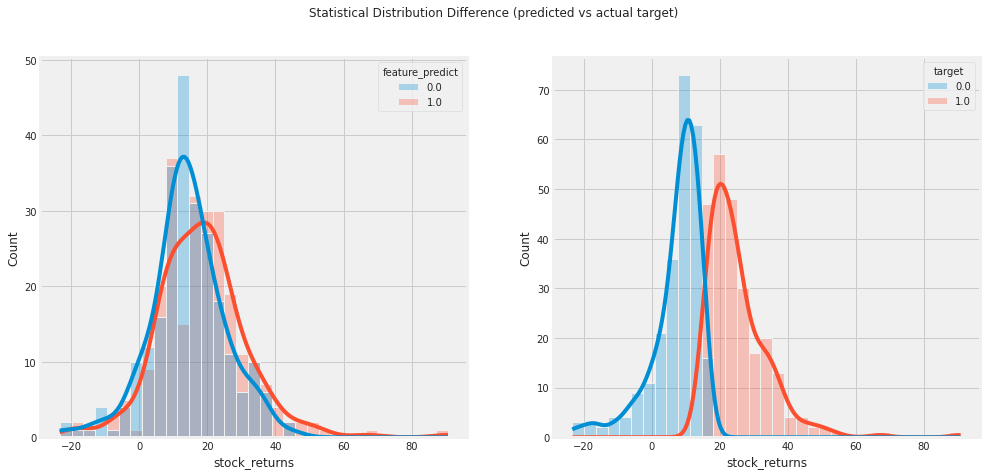

In [ ]:
#Statistical Distribution Difference between our prediction values to the stock returns
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Statistical Distribution Difference (predicted vs actual target)')

sns.histplot(ax=axes[0], data=intersection_df, x='stock_returns', hue='feature_predict', kde=True, fill=True, alpha=0.3, linewidth=1)
sns.histplot(ax=axes[1], data=intersection_df, x='stock_returns', hue='target', kde=True, fill=True, alpha=0.3, linewidth=1)

In the left graph we can see our feature prediction distribution difference and on the right side we can see the target (A.K.A actual) statistical difference

<AxesSubplot:xlabel='feature_predict', ylabel='stock_returns'>

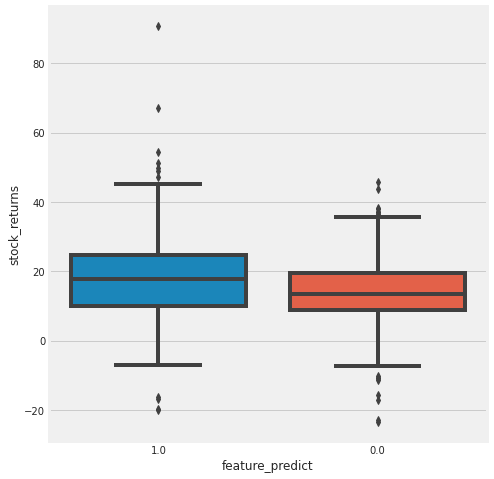

In [ ]:
# Box plot of the stock returns of the stock that were predicted as bad and good
plot_df = intersection_df.copy()
plot_df['feature_predict'] = plot_df['feature_predict'].astype(str)
plot_df['target'] = plot_df['target'].astype(str)

fig, axes = plt.subplots(1, 1, figsize=(7, 8))
sns.boxplot(data=plot_df, y='stock_returns', x='feature_predict')

As we can see the stocks that were predicted as good had slightly higher returns as we expected to see.

In [ ]:
# Calculating the good and bad stocks prediction statistical values

# Predicted as 'good'
mean_1 = intersection_df.loc[intersection_df['feature_predict'] == 1, 'stock_returns'].mean()
median_1 = intersection_df.loc[intersection_df['feature_predict'] == 1, 'stock_returns'].median()
quantile_1 = intersection_df.loc[intersection_df['feature_predict'] == 1, 'stock_returns'].quantile(0.2)
skewness_1 = skew(intersection_df.loc[intersection_df['feature_predict'] == 1, 'stock_returns'])
kurtosis_1 = kurtosis(intersection_df.loc[intersection_df['feature_predict'] == 1, 'stock_returns'])

# Predicted as 'bad'
mean_0 = intersection_df.loc[intersection_df['feature_predict'] == 0, 'stock_returns'].mean()
median_0 = intersection_df.loc[intersection_df['feature_predict'] == 0, 'stock_returns'].median()
quantile_0 = intersection_df.loc[intersection_df['feature_predict'] == 0, 'stock_returns'].quantile(0.2)
skewness_0 = skew(intersection_df.loc[intersection_df['feature_predict'] == 0, 'stock_returns'])
kurtosis_0 = kurtosis(intersection_df.loc[intersection_df['feature_predict'] == 0, 'stock_returns'])

# Creating dataframe
statistics_data = {'Value': ['Mean', 'Median', '20% Percentile', 'Skewness', 'Kurtosis'],
        'Predicted_0': [mean_0, median_0, quantile_0, skewness_0, kurtosis_0],
        'Predicted_1': [mean_1, median_1, quantile_1, skewness_1, kurtosis_1]}

statistics_df = pd.DataFrame(statistics_data)
statistics_df

,Value,Predicted_0,Predicted_1
0,Mean,14.223593,18.273582
1,Median,13.508014,17.820379
2,20% Percentile,7.594309,8.426968
3,Skewness,-0.210200,0.785994
4,Kurtosis,1.123203,4.100713



Train results:
  True positive: 142,
  True negative: 141,
  False positive: 104,
  False negative: 105

Precision: 0.5772357723577236
Recall: 0.5748987854251012


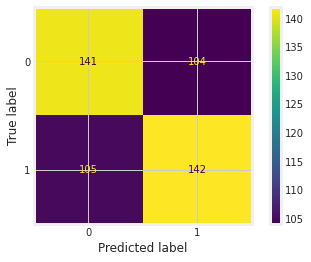

In [ ]:
# Feature based prediction confusion matrix, precision and recall
true_positive = len(intersection_df[(intersection_df['feature_predict'] == intersection_df['target'])&(intersection_df['feature_predict']==True)])
true_negative = len(intersection_df[(intersection_df['feature_predict'] == intersection_df['target'])&(intersection_df['feature_predict']==False)])
false_positive = len(intersection_df[(intersection_df['feature_predict'] != intersection_df['target'])&(intersection_df['feature_predict']==True)])
false_negative = len(intersection_df[(intersection_df['feature_predict'] != intersection_df['target'])&(intersection_df['feature_predict']==False)])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')
matrix = confusion_matrix(intersection_df['target'], intersection_df['feature_predict'])
disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
disp.plot()

feature_precision = precision_score(intersection_df['target'], intersection_df['feature_predict'])
feature_recall = recall_score(intersection_df['target'], intersection_df['feature_predict'])

print('Precision:', feature_precision)
print('Recall:', feature_recall)


Train results:
  True positive: 142,
  True negative: 141,
  False positive: 104,
  False negative: 105

Precision: 0.5772357723577236
Recall: 0.5748987854251012


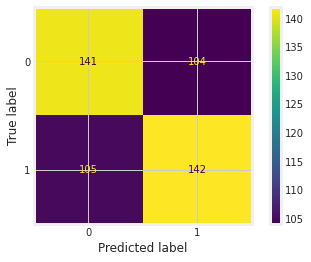

In [ ]:
# Regression based prediction confusion matrix, precision and recall
true_positive = len(intersection_df[(intersection_df['regression_predict'] == intersection_df['target'])&(intersection_df['regression_predict']==True)])
true_negative = len(intersection_df[(intersection_df['regression_predict'] == intersection_df['target'])&(intersection_df['regression_predict']==False)])
false_positive = len(intersection_df[(intersection_df['regression_predict'] != intersection_df['target'])&(intersection_df['regression_predict']==True)])
false_negative = len(intersection_df[(intersection_df['regression_predict'] != intersection_df['target'])&(intersection_df['regression_predict']==False)])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')
matrix = confusion_matrix(intersection_df['target'], intersection_df['regression_predict'])
disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
disp.plot()

regression_precision = precision_score(intersection_df['target'], intersection_df['regression_predict'])
regression_recall = recall_score(intersection_df['target'], intersection_df['regression_predict'])

print('Precision:', regression_precision)
print('Recall:', regression_recall)


As we can see our two algorithms provided the same results which make sense because the second algorithm (the regression) was based on our feature.
The regression was conducted by fitting a line to the feature and the returns and made the prediction for the labeling period based on this line.
since we used the same threshold for both we got the same results.

So in conclusion we managed to find two different algorithms that can predict high performing stocks with the same results.

# **Part 2**

## Calculate Features & Target values for all stocks

In [ ]:
# Creating a monthly df for calculations
features_df = all_features_train_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)
monthly_features_df = features_df.groupby(['stock','sector','sub_sector','month_index']).apply(calculate_returns).reset_index(name = 'monthly_return')

# Min/max price
min_price = features_df.groupby(['stock','month_index'])['Low'].min().reset_index(name = 'min_price')
max_price = features_df.groupby(['stock','month_index'])['High'].max().reset_index(name = 'max_price')
monthly_features_df['min_price'] = min_price['min_price']
monthly_features_df['max_price'] = max_price['max_price']

# Average sector ratio
avg_sector_returns = monthly_features_df.groupby(['sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sector', 'month_index'], right_on=['sector', 'month_index'])
monthly_features_df['stock_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sector_returns']

# Average sub-sector ratio
avg_sector_returns = monthly_features_df.groupby(['sub_sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sub_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sub_sector', 'month_index'], right_on=['sub_sector', 'month_index'])
monthly_features_df['stock_sub_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sub_sector_returns']

# Average index ratio
avg_index_returns = monthly_features_df.groupby('month_index')['monthly_return'].mean().reset_index(name = 'avg_index_returns')
monthly_features_df = monthly_features_df.merge(avg_index_returns, how='inner', left_on='month_index', right_on='month_index')
monthly_features_df['stock_index_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_index_returns']

# 6 month return
all_6_month_return = features_df.groupby('stock').apply(calculate_returns).reset_index(name='6_month_return')

# Total volume
total_volume = features_df.groupby(['stock','month_index'])['Volume'].sum().reset_index(name = 'total_volume')
monthly_features_df['total_volume'] = total_volume['total_volume'] / 1000000

# Standard deviation
std = features_df.groupby(['stock'])['Close'].std().reset_index(name = 'std')

In [ ]:
# Calculating each stock best and worst monthly return to be used as our features
# Average monthly return
avg_monthly_return = monthly_features_df.groupby(['stock','sector'])['monthly_return'].mean().reset_index(name = 'avg_monthly_return')
train_df = avg_monthly_return[['stock','sector','avg_monthly_return']]

# Best/Worst return
worst_month = monthly_features_df.groupby('stock').min().reset_index()
best_month = monthly_features_df.groupby('stock').max().reset_index()
train_df['best_month'] = best_month['monthly_return']
train_df['worst_month'] = worst_month['monthly_return']

# min/max price
highest_price = monthly_features_df.groupby('stock')['max_price'].max().reset_index()
lowest_price = monthly_features_df.groupby('stock')['min_price'].min().reset_index()
train_df['max_min_ratio'] = lowest_price['min_price'] / highest_price['max_price']

# average sub-sector ratio
average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
train_df['average_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

# average sector ratio
average_sub_sector_ratio = monthly_features_df.groupby('stock')['stock_sub_sector_ratio'].mean().reset_index()
train_df['average_sub_sector_ratio'] = average_sub_sector_ratio['stock_sub_sector_ratio']

# Average index ratio
average_index_ratio = monthly_features_df.groupby('stock')['stock_index_ratio'].mean().reset_index()
train_df['average_index_ratio'] = average_index_ratio['stock_index_ratio']

# 6 month return
train_df['6_month_return'] = all_6_month_return['6_month_return']

# Total volume
train_df['total_volume'] = total_volume['total_volume']

# Standard Deviation
train_df['std'] = std['std']

In [ ]:
# Adding a binary target column for our classification based on the labelling
train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()

train_df

,stock,sector,avg_monthly_return,best_month,worst_month,max_min_ratio,average_sector_ratio,average_sub_sector_ratio,average_index_ratio,6_month_return,total_volume,std,target
0,A,Health Care Equipment,1.692341,14.643142,-12.167507,0.807637,1.162881,2.154163,3.045757,7.990694,75883800.0,2.848307,1.0
1,AAL,Airlines,-1.426685,20.368315,-21.275071,0.676046,1.078273,1.000000,2.604932,-15.206294,109485000.0,2.992651,0.0
2,AAP,Automotive Retail,2.892148,15.143738,-12.585137,0.716480,2.431715,0.029618,3.155113,15.240618,74921000.0,11.670712,0.0
3,AAPL,"Technology Hardware, Storage & Peripherals",-3.131172,13.402901,-14.469523,0.630066,-3.548156,1.000000,0.781017,-14.413591,116399200.0,5.091196,1.0
4,ABBV,Pharmaceuticals,0.345185,8.556104,-13.204198,0.781493,0.543184,2.085625,0.137711,1.059439,128795000.0,3.684236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,YUM,Restaurants,3.074662,9.015844,-6.128507,0.812099,1.811008,0.936879,3.160524,19.176358,19693600.0,4.200894,0.0
488,ZBH,Health Care Equipment,-0.632531,13.603048,-12.533197,0.722180,1.035514,1.000000,3.396475,-6.704396,20461600.0,7.343014,1.0
489,ZBRA,Electronic Equipment & Instruments,2.055780,23.944695,-13.465381,0.736996,1.152296,0.538264,3.535418,9.923181,34117600.0,11.657389,1.0
490,ZION,Regional Banks,-3.870144,2.964435,-15.559756,0.699644,0.751065,1.903099,-1.395735,-21.979984,50003400.0,3.347818,0.0


## Train the model

In [ ]:
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df[['avg_monthly_return','best_month','worst_month', 'max_min_ratio', 'average_sector_ratio','average_sub_sector_ratio', 'average_index_ratio', '6_month_return', 'total_volume', 'std']], train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

## Testing the model on 12 periods

period 1:
Precision: 0.7074829931972789
Recall: 0.41935483870967744
------------------------------
period 2:
Precision: 0.5568862275449101
Recall: 0.375
------------------------------
period 3:
Precision: 0.5181818181818182
Recall: 0.22983870967741934
------------------------------
period 4:
Precision: 0.4485981308411215
Recall: 0.19433198380566802
------------------------------
period 5:
Precision: 0.3559322033898305
Recall: 0.1700404858299595
------------------------------
period 6:
Precision: 0.625
Recall: 0.16194331983805668
------------------------------
period 7:
Precision: 0.5340909090909091
Recall: 0.9437751004016064
------------------------------
period 8:
Precision: 0.5052410901467506
Recall: 0.9678714859437751
------------------------------
period 9:
Precision: 0.49056603773584906
Recall: 0.9397590361445783
------------------------------
period 10:
Precision: 0.5042016806722689
Recall: 0.963855421686747
------------------------------
period 11:
Precision: 0.49894736842105264

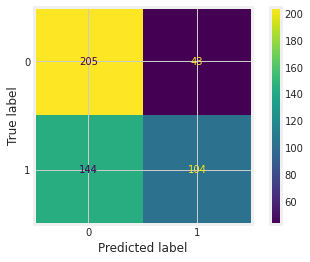

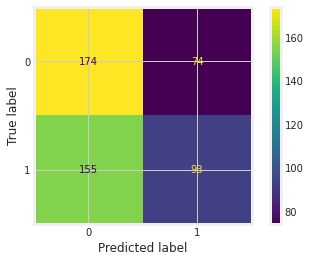

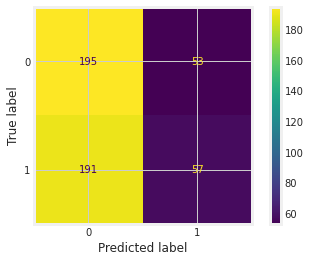

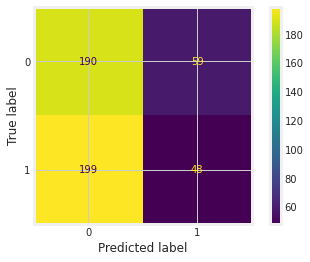

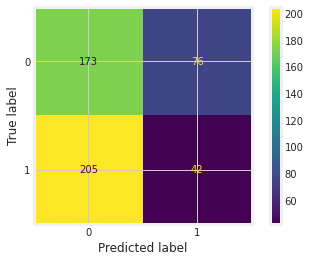

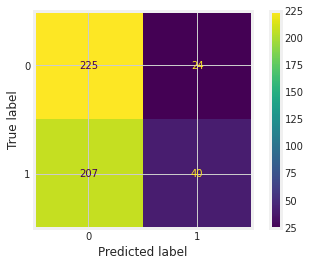

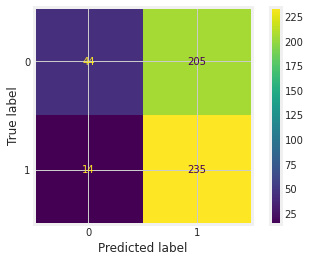

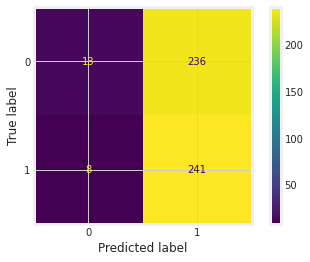

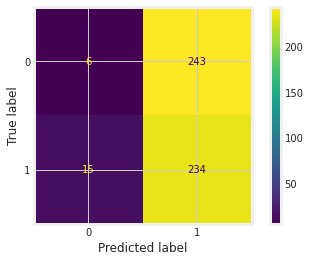

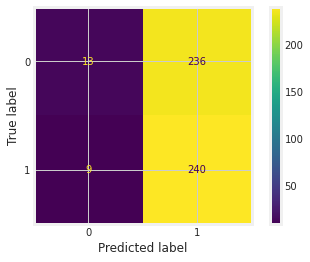

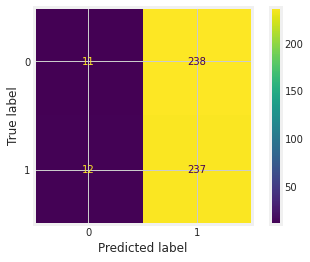

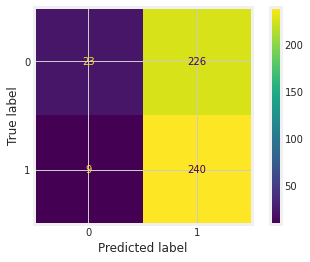

In [ ]:
for i in range(12):
  start_test_features_day = 270 + (i)*30
  end_test_features_day = start_test_features_day + FEATURES_SIZE
  start_test_labelling_day = end_test_features_day + 1 
  end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE

  all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
  all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day)&(all_df['t0'] < end_test_labelling_day)]

  features_df = all_features_test_df.copy()
  features_df['month_index'] = (features_df['t0'] / 30).astype(int)
  monthly_features_df = features_df.groupby(['stock','sector','sub_sector','month_index']).apply(calculate_returns).reset_index(name = 'monthly_return')

  # min/max price
  min_price = features_df.groupby(['stock','month_index'])['Low'].min().reset_index(name = 'min_price')
  max_price = features_df.groupby(['stock','month_index'])['High'].max().reset_index(name = 'max_price')
  monthly_features_df['min_price'] = min_price['min_price']
  monthly_features_df['max_price'] = max_price['max_price']

  # average sector ratio
  avg_sector_returns = monthly_features_df.groupby(['sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sector_returns')
  monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sector', 'month_index'], right_on=['sector', 'month_index'])
  monthly_features_df['stock_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sector_returns']

  # average sub-sector ratio
  avg_sector_returns = monthly_features_df.groupby(['sub_sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sub_sector_returns')
  monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sub_sector', 'month_index'], right_on=['sub_sector', 'month_index'])
  monthly_features_df['stock_sub_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sub_sector_returns']

  # Average index ratio
  avg_index_returns = monthly_features_df.groupby('month_index')['monthly_return'].mean().reset_index(name = 'avg_index_returns')
  monthly_features_df = monthly_features_df.merge(avg_index_returns, how='inner', left_on='month_index', right_on='month_index')
  monthly_features_df['stock_index_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_index_returns']

  # 6 month return
  all_6_month_return = features_df.groupby('stock').apply(calculate_returns).reset_index(name='6_month_return')

  # Total volume
  total_volume = features_df.groupby(['stock','month_index'])['Volume'].sum().reset_index(name = 'total_volume')
  monthly_features_df['total_volume'] = total_volume['total_volume'] / 1000000

  # Standard deviation
  std = features_df.groupby(['stock'])['Close'].std().reset_index(name = 'std')

  # Average monthly return
  avg_monthly_return = monthly_features_df.groupby(['stock','sector'])['monthly_return'].mean().reset_index(name = 'avg_monthly_return')
  test_df = avg_monthly_return[['stock','sector','avg_monthly_return']]

  # Best/Worst price
  worst_month = monthly_features_df.groupby('stock').min().reset_index()
  best_month = monthly_features_df.groupby('stock').max().reset_index()
  test_df['best_month'] = best_month['monthly_return']
  test_df['worst_month'] = worst_month['monthly_return']

  # min/max price
  highest_price = monthly_features_df.groupby('stock')['max_price'].max().reset_index()
  lowest_price = monthly_features_df.groupby('stock')['min_price'].min().reset_index()
  test_df['max_min_ratio'] = lowest_price['min_price'] / highest_price['max_price']

  # average sector ratio
  average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
  test_df['average_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

  # average sub-sector ratio
  average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
  test_df['average_sub_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

  # Average index ratio
  average_index_ratio = monthly_features_df.groupby('stock')['stock_index_ratio'].mean().reset_index()
  test_df['average_index_ratio'] = average_index_ratio['stock_index_ratio']

  # 6 month return
  test_df['6_month_return'] = all_6_month_return['6_month_return']

  # Total volume
  test_df['total_volume'] = total_volume['total_volume']

  # Standard Deviation
  test_df['std'] = std['std']

  test_df['predicted_y'] = clf.predict(test_df[['avg_monthly_return','best_month','worst_month', 'max_min_ratio', 'average_sector_ratio','average_sub_sector_ratio', 'average_index_ratio', '6_month_return', 'total_volume', 'std']])

  test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
  label_threshold = test_returns.median()
  good_test = test_returns[test_returns > label_threshold].index
  test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
  test_df['actual_y'].fillna(0,inplace=True)

  precision = precision_score(test_df['actual_y'], test_df['predicted_y'])
  recall = recall_score(test_df['actual_y'], test_df['predicted_y'])
  matrix = confusion_matrix(test_df['actual_y'], test_df['predicted_y'])
  disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
  disp.plot()
  print('period ' + str(i+1) + ':')
  print('Precision:', precision)
  print('Recall:', recall)
  print('-'*30)

## Retrain our model starting from August 2018

We tried to look at the graph of the s&p500 on trading view and find a period that looks as close as possible to the time that we are interested to choose our portfolio (june 2022) in terms of volatility, prices, volume etc...

We've found out that August 2018 looks similar to june 2022 so we chose it.

In [ ]:
# Split the data to segments (6 months features, 3 months labelling)
start_train_features_day = 30
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1 
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE

all_features_train_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
all_labelling_train_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]

In [ ]:
# Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))

# Set the threshold to be a little bit higher (60% percentile) to choose better stocks
threshold = train_returns.quantile(0.6)
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

In [ ]:
# Creating a monthly df for calculations
features_df = all_features_train_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)
monthly_features_df = features_df.groupby(['stock','sector','sub_sector','month_index']).apply(calculate_returns).reset_index(name = 'monthly_return')

# Min/max price
min_price = features_df.groupby(['stock','month_index'])['Low'].min().reset_index(name = 'min_price')
max_price = features_df.groupby(['stock','month_index'])['High'].max().reset_index(name = 'max_price')
monthly_features_df['min_price'] = min_price['min_price']
monthly_features_df['max_price'] = max_price['max_price']

# Average sector ratio
avg_sector_returns = monthly_features_df.groupby(['sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sector', 'month_index'], right_on=['sector', 'month_index'])
monthly_features_df['stock_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sector_returns']

# Average sub-sector ratio
avg_sector_returns = monthly_features_df.groupby(['sub_sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sub_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sub_sector', 'month_index'], right_on=['sub_sector', 'month_index'])
monthly_features_df['stock_sub_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sub_sector_returns']

# Average index ratio
avg_index_returns = monthly_features_df.groupby('month_index')['monthly_return'].mean().reset_index(name = 'avg_index_returns')
monthly_features_df = monthly_features_df.merge(avg_index_returns, how='inner', left_on='month_index', right_on='month_index')
monthly_features_df['stock_index_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_index_returns']

# 6 month return
all_6_month_return = features_df.groupby('stock').apply(calculate_returns).reset_index(name='6_month_return')

# Total volume
total_volume = features_df.groupby(['stock','month_index'])['Volume'].sum().reset_index(name = 'total_volume')
monthly_features_df['total_volume'] = total_volume['total_volume'] / 1000000

# Standard deviation
std = features_df.groupby(['stock'])['Close'].std().reset_index(name = 'std')

In [ ]:
# Calculating each stock best and worst monthly return to be used as our features
# Average monthly return
avg_monthly_return = monthly_features_df.groupby(['stock','sector'])['monthly_return'].mean().reset_index(name = 'avg_monthly_return')
train_df = avg_monthly_return[['stock','sector','avg_monthly_return']]

# Best/Worst return
worst_month = monthly_features_df.groupby('stock').min().reset_index()
best_month = monthly_features_df.groupby('stock').max().reset_index()
train_df['best_month'] = best_month['monthly_return']
train_df['worst_month'] = worst_month['monthly_return']

# min/max price
highest_price = monthly_features_df.groupby('stock')['max_price'].max().reset_index()
lowest_price = monthly_features_df.groupby('stock')['min_price'].min().reset_index()
train_df['max_min_ratio'] = lowest_price['min_price'] / highest_price['max_price']

# average sub-sector ratio
average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
train_df['average_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

# average sector ratio
average_sub_sector_ratio = monthly_features_df.groupby('stock')['stock_sub_sector_ratio'].mean().reset_index()
train_df['average_sub_sector_ratio'] = average_sub_sector_ratio['stock_sub_sector_ratio']

# Average index ratio
average_index_ratio = monthly_features_df.groupby('stock')['stock_index_ratio'].mean().reset_index()
train_df['average_index_ratio'] = average_index_ratio['stock_index_ratio']

# 6 month return
train_df['6_month_return'] = all_6_month_return['6_month_return']

# Total volume
train_df['total_volume'] = total_volume['total_volume']

# Standard Deviation
train_df['std'] = std['std']

In [ ]:
# Adding a binary target column for our classification based on the labelling
train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()

0.0    294
1.0    198
Name: target, dtype: int64

In [ ]:
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df[['avg_monthly_return','best_month','worst_month', 'max_min_ratio', 'average_sector_ratio','average_sub_sector_ratio', 'average_index_ratio', '6_month_return', 'total_volume', 'std']], train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

## Choose stocks for our portfolio based on the new model

In [ ]:
# Setting our start test festures day to be at July 2022
start_test_features_day = 1249
end_test_features_day = start_test_features_day + FEATURES_SIZE
start_test_labelling_day = end_test_features_day + 1 
end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE

all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]
all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day)&(all_df['t0'] < end_test_labelling_day)]

In [ ]:
features_df = all_features_test_df.copy()
features_df['month_index'] = (features_df['t0'] / 30).astype(int)
monthly_features_df = features_df.groupby(['stock','sector','sub_sector','month_index']).apply(calculate_returns).reset_index(name = 'monthly_return')

# min/max price
min_price = features_df.groupby(['stock','month_index'])['Low'].min().reset_index(name = 'min_price')
max_price = features_df.groupby(['stock','month_index'])['High'].max().reset_index(name = 'max_price')
monthly_features_df['min_price'] = min_price['min_price']
monthly_features_df['max_price'] = max_price['max_price']

# average sector ratio
avg_sector_returns = monthly_features_df.groupby(['sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sector', 'month_index'], right_on=['sector', 'month_index'])
monthly_features_df['stock_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sector_returns']

# average sub-sector ratio
avg_sector_returns = monthly_features_df.groupby(['sub_sector', 'month_index'])['monthly_return'].mean().reset_index(name = 'avg_sub_sector_returns')
monthly_features_df = monthly_features_df.merge(avg_sector_returns, how='inner', left_on=['sub_sector', 'month_index'], right_on=['sub_sector', 'month_index'])
monthly_features_df['stock_sub_sector_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_sub_sector_returns']

# Average index ratio
avg_index_returns = monthly_features_df.groupby('month_index')['monthly_return'].mean().reset_index(name = 'avg_index_returns')
monthly_features_df = monthly_features_df.merge(avg_index_returns, how='inner', left_on='month_index', right_on='month_index')
monthly_features_df['stock_index_ratio'] = monthly_features_df['monthly_return'] / monthly_features_df['avg_index_returns']

# 6 month return
all_6_month_return = features_df.groupby('stock').apply(calculate_returns).reset_index(name='6_month_return')

# Total volume
total_volume = features_df.groupby(['stock','month_index'])['Volume'].sum().reset_index(name = 'total_volume')
monthly_features_df['total_volume'] = total_volume['total_volume'] / 1000000

# Standard deviation
std = features_df.groupby(['stock'])['Close'].std().reset_index(name = 'std')

In [ ]:
# Average monthly return
avg_monthly_return = monthly_features_df.groupby(['stock','sector'])['monthly_return'].mean().reset_index(name = 'avg_monthly_return')
test_df = avg_monthly_return[['stock','sector','avg_monthly_return']]

# Best/Worst price
worst_month = monthly_features_df.groupby('stock').min().reset_index()
best_month = monthly_features_df.groupby('stock').max().reset_index()
test_df['best_month'] = best_month['monthly_return']
test_df['worst_month'] = worst_month['monthly_return']

# min/max price
highest_price = monthly_features_df.groupby('stock')['max_price'].max().reset_index()
lowest_price = monthly_features_df.groupby('stock')['min_price'].min().reset_index()
test_df['max_min_ratio'] = lowest_price['min_price'] / highest_price['max_price']

# average sector ratio
average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
test_df['average_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

# average sub-sector ratio
average_sector_ratio = monthly_features_df.groupby('stock')['stock_sector_ratio'].mean().reset_index()
test_df['average_sub_sector_ratio'] = average_sector_ratio['stock_sector_ratio']

# Average index ratio
average_index_ratio = monthly_features_df.groupby('stock')['stock_index_ratio'].mean().reset_index()
test_df['average_index_ratio'] = average_index_ratio['stock_index_ratio']

# 6 month return
test_df['6_month_return'] = all_6_month_return['6_month_return']

# Total volume
test_df['total_volume'] = total_volume['total_volume']

# Standard Deviation
test_df['std'] = std['std']

test_df

,stock,sector,avg_monthly_return,best_month,worst_month,max_min_ratio,average_sector_ratio,average_sub_sector_ratio,average_index_ratio,6_month_return,total_volume,std
0,A,Health Care Equipment,-1.574451,14.910649,-13.440650,0.694659,1.569069,1.569069,0.627553,-11.481874,20761000.0,11.708513
1,AAL,Airlines,2.880490,20.868941,-24.583107,0.580766,0.986284,0.986284,2.585246,9.945418,73681000.0,1.386401
2,AAP,Automotive Retail,-1.613132,9.801605,-9.493152,0.711996,0.658453,0.658453,0.913532,-11.348739,70328800.0,14.115069
3,AAPL,"Technology Hardware, Storage & Peripherals",-0.153407,13.046493,-12.679888,0.726872,2.954565,2.954565,1.120705,-5.473872,108367000.0,10.239501
4,ABBV,Pharmaceuticals,4.039181,12.671671,-9.484664,0.650405,0.625968,0.625968,0.932069,31.479230,74488400.0,12.523578
...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Restaurants,-0.047890,10.699473,-8.487396,0.779792,0.917839,0.917839,0.910510,-2.458402,78427600.0,7.046905
496,ZBH,Health Care Equipment,0.534720,6.411498,-10.777219,0.778296,0.372433,0.372433,0.990910,2.920703,57372200.0,4.508590
497,ZBRA,Electronic Equipment & Instruments,-6.537334,10.109301,-23.456971,0.502439,1.481091,1.481091,1.154511,-40.859400,12304800.0,88.571428
498,ZION,Regional Banks,-0.755078,11.602038,-16.130550,0.679147,0.443474,0.443474,1.145418,-8.346094,35094800.0,5.337612


In [ ]:
test_df['predicted_y'] = clf.predict(test_df[['avg_monthly_return','best_month','worst_month', 'max_min_ratio', 'average_sector_ratio','average_sub_sector_ratio', 'average_index_ratio', '6_month_return', 'total_volume', 'std']])

test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
label_threshold = test_returns.quantile(0.6)
good_test = test_returns[test_returns > label_threshold].index
test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
test_df['actual_y'].fillna(0,inplace=True)

my_portfolio = test_df.loc[test_df['predicted_y'] == 1]['stock'].tolist()
portfolio_df = all_labelling_test_df.loc[all_labelling_test_df['stock'].isin(my_portfolio)]

# Making sure our portfolio has at least 50 stocks and under 300 stocks
print(len(my_portfolio))
print(my_portfolio)

62
['AAPL', 'ABBV', 'ABC', 'ADM', 'ALGN', 'ALL', 'APA', 'ATVI', 'BKR', 'BMY', 'CAH', 'CEG', 'CF', 'CI', 'COP', 'CTRA', 'CTVA', 'CVX', 'DAL', 'DVN', 'DXCM', 'ENPH', 'EOG', 'EPAM', 'EQT', 'ETSY', 'EXPE', 'EXR', 'FANG', 'FMC', 'HAL', 'HES', 'JKHY', 'KR', 'LLY', 'LMT', 'LW', 'LYB', 'MCK', 'MOS', 'MPC', 'MRO', 'NDSN', 'NEM', 'NFLX', 'NOC', 'NUE', 'OTIS', 'OXY', 'PM', 'PSX', 'PXD', 'PYPL', 'SLB', 'SRE', 'STLD', 'TRGP', 'UAL', 'VLO', 'VRTX', 'VTR', 'XOM']


## Calculating sharpe ratio and comparing to the index

The risk-free rate that was used for the formula was 4.72% based on the United-States 3 Month Treasury Bill Rate

In [ ]:
# Portfolio sharpe
portfolio_returns = portfolio_df.groupby('stock').apply(lambda x: calculate_returns(x))
expected_portfolio_returns = portfolio_returns.mean()
portfolio_std = portfolio_returns.std()
portfolio_sharpe = (expected_portfolio_returns - 0.0472) / portfolio_std

# Index sharpe
index_returns = all_labelling_test_df.groupby('stock').apply(lambda x: calculate_returns(x))
expected_index_returns = index_returns.mean()
index_std = index_returns.std()
index_sharpe = (expected_index_returns - 0.0472) / index_std

# Creating dataframe
sharpe_data = {'portfolio': ['s&p500', 'model'],
        'sharpe ratio': [index_sharpe, portfolio_sharpe]}
sharpe_df = pd.DataFrame(sharpe_data)
sharpe_df

,portfolio,sharpe ratio
0,s&p500,-0.309881
1,model,-0.060512


As we can see our portfolio has better sharpe ratio than the index (A.K.A "market portfolio").

# **Part 3**

In [ ]:
all_df_strategy = pd.read_csv(fname_string, index_col='Date', parse_dates=True)
all_df_strategy = all_df_strategy['2022-06-01':'2022-09-01']

all_df_strategy

,Open,High,Low,Close,Volume,stock,sector,sub_sector,Adj Close
Date,,,,,,,,,
2022-06-01,144.193157,144.347656,140.591470,141.383255,2410400.0,MMM,Industrial Conglomerates,"Saint Paul, Minnesota",NaN
2022-06-02,142.445433,143.188935,139.529314,143.082718,1901400.0,MMM,Industrial Conglomerates,"Saint Paul, Minnesota",NaN
2022-06-03,141.943313,142.397147,140.321111,140.948746,1876300.0,MMM,Industrial Conglomerates,"Saint Paul, Minnesota",NaN
2022-06-06,141.354282,142.232982,140.639732,141.180481,1575600.0,MMM,Industrial Conglomerates,"Saint Paul, Minnesota",NaN
2022-06-07,140.436962,141.933646,138.872694,141.817764,1805300.0,MMM,Industrial Conglomerates,"Saint Paul, Minnesota",NaN
...,...,...,...,...,...,...,...,...,...
2022-08-26,164.971009,165.498644,158.947986,159.176956,1468000.0,ZTS,Pharmaceuticals,"Parsippany, New Jersey",NaN
2022-08-29,157.604010,158.430311,156.827490,157.165970,1236900.0,ZTS,Pharmaceuticals,"Parsippany, New Jersey",NaN
2022-08-30,157.773252,158.042052,156.060921,156.379501,1918800.0,ZTS,Pharmaceuticals,"Parsippany, New Jersey",NaN


In [ ]:
class SmaCross(Strategy):
    n1 = 9
    n2 = 18

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
            
def calculate_portfolio_stats(all_data, portfolio_stocks):
    '''
        all_data: pd.Dataframe, needs to include all your required stocks OHLCV data.
        portfolio_stocks: List[str], list of your required portfolio stock tickers for an example: ['AAPL','TSLA'].
        must be consistentr with the stocks column uin your all_data df
    '''
    assert len(portfolio_stocks) > 1, 'portfolio must include more than one stock'
    returns = []
    sharpes = []
    for stock in portfolio_stocks:
        if stock == 'A': continue
        stock_data = all_data[all_data['stock'] == stock][['Open', 'High', 'Low', 'Close', 'Volume']]
        bt = Backtest(stock_data, SmaCross,
                    cash=10000, commission=.002,
                    exclusive_orders=True)
        output = bt.run()
        sharpes.append(output.loc['Sharpe Ratio'])
        returns.append(output.loc['Return [%]'])
    mean_returns = mean(returns)
    returns_std = stdev(returns)
    mean_sharpes = mean(sharpes)
    sharpes_std = stdev(sharpes)
    bt.run()
    return mean_returns, returns_std, mean_sharpes, sharpes_std

In [ ]:
calculate_portfolio_stats(all_df_strategy, my_portfolio)

<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipython-input-143-b73105d1dbb0>:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(stock_data, SmaCross,
<ipyth

(7.4208520499070625,
 13.074598625823546,
 0.9122337884148656,
 0.8156398317804138)

As we can see we got much better results compared to our "buy & hold" in terms of sharpe ratio and that is since our trading strategy took advantage of using the fact of a bear market by shorting.